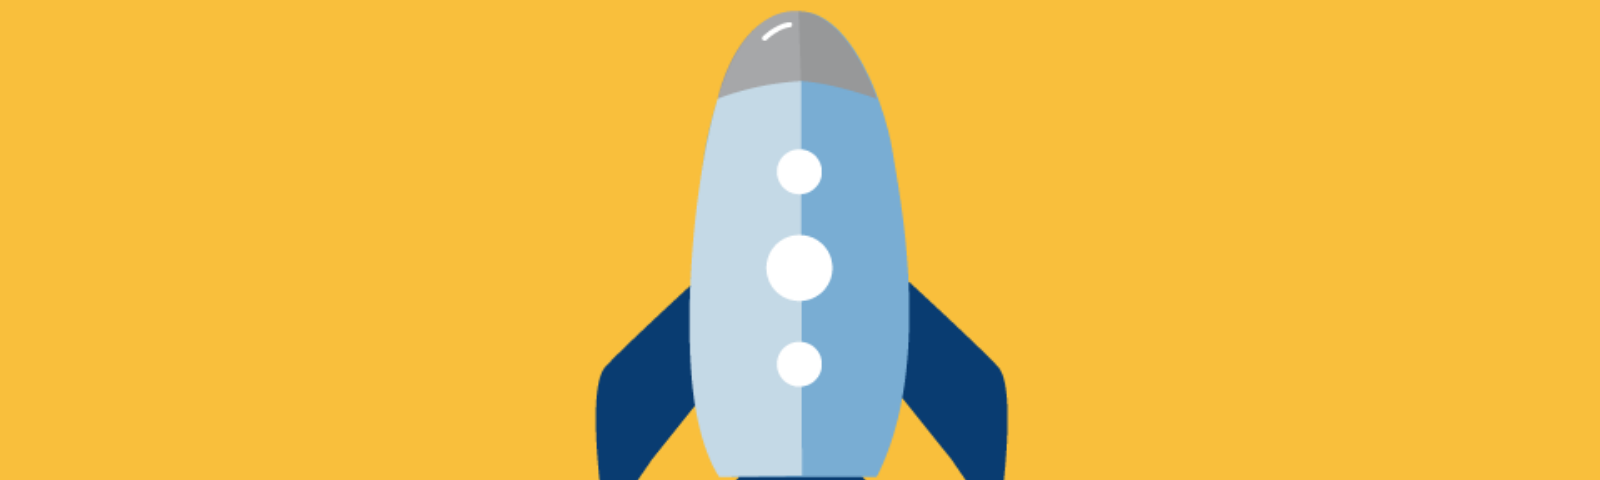
# Introduction ⚡

In this notebook you will find a solution based on CatBoost. This algorithm is developed by Yandex and its famous the categorical feature handling (this is the reason for "cat" prefix in the name), easy parameter tuning and last but not least, the easy GPU scalability without extra tuning.

Based on the Yandex the algorithm term is the following:
*CatBoost is an algorithm for gradient boosting on decision trees. It is developed by Yandex researchers and engineers, and is used for search, recommendation systems, personal assistant, self-driving cars, weather prediction and many other tasks at Yandex and in other companies, including CERN, Cloudflare, Careem taxi. It is in open-source and can be used by anyone.*

*NOTE: In this notebook it's not included the EDA, it contains only what is related with CatBoost model*

## Things that worked 🔥
* One global per Family. That means 33 isolated models.
    * NOTE: Each Family model is a global model because it contains one timeseries for each store (54 timeseries)
* Set the categorical columns
* Create many features based on promotions (total, per family, rolling avgs, lags etc)
* The logarithm transformation (`log1p`) in target
* The Upgini extra features for `LIQUOR,WINE,BEER`, `CLEANING` product families for a slight improvement.
* Add `sample_weight` in the fitting with extra weight from `2017-07-01`

---

## Things that not gone well 💩
* RandomForest, ExtraTrees and other Gradient Boosting algorithms (XGBoost, LightGBM) had worse perfomance in my case.
* Model approches which didn't worked so well:
   * One global model
   * One global model per Store
* Feature transformations (MinMaxScaler, StandardScaler). The main models I worked were tree based models (RandomForest, ExtraTrees, XGBoost, LightGBM etc) which are models where feature scaling doesn’t make a difference.
* PCA for dimentionality reduction
* Feature Selection ([SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest),[RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV))
* Upgini features for all families
* A training sub-period. Instead of using the data from 2013, I tried to use a smaller range of dates e.g starting from 2014, 2015
..

---

## Conclusion 💁
Yandex had made amazing job with the CatBoost implementation, its amazing how easily and FAST work out of the box. 
Before, CatBoost I achieved a score below 0.40 with ExtraTrees & BaggingRegressor, but the solution was much more complex and slower (it took approximately 5hours+)

The GPU acceleration is also a great feature!! I achieved to run a so powerful model in less than an hour 😍. Also Kaggle support free GPU acceleration with 30hours of quotas for a period of time, which is more than enough for this problem.

---

## Special Thanks 👏
Last but not least, I would like to thanks other competitors solutions for their great ideas:
* A great EDA: [Store Sales TS Forecasting - A Comprehensive Guide by Ekrem Bayar](https://www.kaggle.com/code/ekrembayar/store-sales-ts-forecasting-a-comprehensive-guide/notebook)
* A compact initial solution: [Simple TS + Ridge + RF](https://www.kaggle.com/code/dkomyagin/simple-ts-ridge-rf/notebook) by KDJ2020
* A nice idea of Linear Regression and Random Forest [Store_Sales_Using_LR_And_RF](https://www.kaggle.com/code/mr0024/store-sales-using-lr-and-rf)

---

# Generic Imports

Imports that will be used in different places \
*NOTE: Generally I prefer to import the libraries in the shell we need them,
this strategy makes the code modular and easy to copy/paste in different
notebooks*

In [ ]:
import sys
import pandas as pd
import numpy as np

from IPython.core import display as ICD

In [ ]:
# Supress few warnings and set few options before the modeling
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.plotting.backend = "plotly"
pd.set_option('mode.chained_assignment', None)
pd.reset_option("mode.chained_assignment")

**Install upgini.** \
*NOTE: This is used in Kaggle env, in your local you can simple install it once in your virtual env*

In [ ]:
!pip install upgini

# Load Data

In [ ]:
# Create a didtionary in order to keep all the datasets in one place
datasets = {}

In [ ]:
sales_df = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv',
                          dtype={
                            'store_nbr': 'category',
                            'family': 'category',
                            'onpromotion': 'uint32'
                            },
                         parse_dates=['date'],
                         date_parser= lambda x: pd.to_datetime(x, format='%Y-%m-%d').to_period('D'),
                         infer_datetime_format=True,
                         index_col=['date', 'store_nbr', 'family'],
                         usecols = ['date', 'store_nbr', 'family','onpromotion', 'sales'])
datasets['sales_init'] = sales_df

In [ ]:
test_df = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv',
                          dtype={
                            'store_nbr': 'category',
                            'family': 'category',
                            'onpromotion': 'uint32'
                            },
                         parse_dates=['date'],
                         date_parser= lambda x: pd.to_datetime(x, format='%Y-%m-%d').to_period('D'),
                         infer_datetime_format=True,
                         index_col=['date', 'store_nbr', 'family'],
                         usecols = ['date', 'store_nbr', 'family','onpromotion'])
datasets['test_init'] = test_df

In [ ]:
holidays_df = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv',
                           dtype={
                             # Used str insted of category
                             'type': 'str',
                             'locale': 'str',
                             'locale_name': 'str',
                             'transferred': 'boolean'
                             },
                          parse_dates=['date'],
                          date_parser= lambda x: pd.to_datetime(x, format='%Y-%m-%d').to_period('D'),
                          infer_datetime_format=True,
                          index_col=['date'],
                          usecols = ['date', 'type', 'locale','locale_name','transferred'])
datasets['holidays_init'] = holidays_df

In [ ]:
oil_df = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv',
                     parse_dates=['date'],
                     date_parser= lambda x: pd.to_datetime(x, format='%Y-%m-%d').to_period('D'),
                     infer_datetime_format=True,
                     index_col=['date'])
datasets['oil_init'] = oil_df

In [ ]:
transactions_df = pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv',
                          dtype={
                            'store_nbr': 'category',
                            'transactions': 'int'
                            },
                         parse_dates=['date'],
                         date_parser= lambda x: pd.to_datetime(x, format='%Y-%m-%d').to_period('D'),
                         infer_datetime_format=True,
                         index_col=['date', 'store_nbr'],
                         usecols = ['date', 'store_nbr', 'transactions'])
datasets['transactions_init'] = transactions_df          

In [ ]:
stores_df = pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv',
                          dtype={
                            'store_nbr': 'category',
                            'city':  'category',
                            'state':  'category',
                            'cluster':  'category',
                            },
                         usecols = ['store_nbr', 'city', 'state', 'cluster', 'type'])
datasets['stores_init'] = stores_df   

Let's check the size of the contents of the dataset dictionary:

In [ ]:
all_df_size_mb = sum([sys.getsizeof(df) for df in datasets.values()]) / 10**6
print(f'All dataframes reserve {all_df_size_mb} MB')

# Data Preprocessing

Create some usefull helper functions for our analysis:

In [ ]:
def dataset_preview(df, head=3):
    print('='*50)
    print('Preview:')
    ICD.display(df.head(head))
    print('*'*50)
    print('Describe:')
    ICD.display(df.describe())
    print('*'*50)
    print('Info:')
    print(df.info())
    print('='*50)
    
def create_lags(df, target_col, lags=1, suffix='_lag', drop_target=True):
    for i in range(1, lags + 1) :
        df[f'{target_col}({suffix}{i})'] = df[target_col].shift(i)
    if drop_target:
        df = df.drop(columns=[target_col])
    return df

## Adding features based on Stores origins

In [ ]:
stores_df = datasets['stores_init'].copy()

In [ ]:
# This feature are for areas with only one store
stores_df['uniquestore'] = stores_df['city'].apply(lambda x: 0 if x in ['Quito', 'Guayaquil', 'Santo Domingo', 'Cuenca', 'Manta', 'Machala', 'Latacunga', 'Ambato'] else 1)
# This feature is for stores which open in train/test period
stores_df['newstore'] = stores_df['store_nbr'].apply(lambda x: 1 if x in [19, 20, 21, 28, 35, 41, 51, 52] else 0)
stores_df = stores_df.rename(columns={'type' : 'store'}) 
stores_df = stores_df.set_index('store_nbr')

In [ ]:
# We can also add the new dataframe in the dataframes dict for future reference :-)
datasets['stores_trans'] = stores_df

## Calendar Datasets
At this point we will create an very important feature dataset. \
This dataset will have rows for the whole period (training data + test data, which is 2013-01-01 --> 2017-08-31) \

In [ ]:
# Explore the given holidays dataset
dataset_preview(datasets['holidays_init'])

In [ ]:
# The total range of dates training data + test data are 2013-01-01 --> 2017-08-31
total_days_range = pd.Series(pd.date_range('2013-01-01', '2017-08-31').to_period('D'), name='date')

calendar_df = pd.DataFrame(index=total_days_range)

# Merge the alendar dataframe with the holidays dataset
calendar_df = calendar_df.merge(datasets['holidays_init'], how='left',on=['date'])
calendar_df.head()

The reason we have NaN values in calendar is the following:
In the calendar dataframe we have rows for the whole period (2013-01-01 --> 2017-08-31); \
but on the other hand in holidays dataframe we have rows only for holidays.

In [ ]:
# We can map the missing rows as work days
calendar_df.loc[calendar_df.isna().any(axis=1), ['type', 'locale', 'locale_name', 'transferred']] = 'Work Day', 'National', 'Ecuador', False
calendar_df.head()

## Apply corrections based on holidays

Holiday types in type column:
* Work Day
* Bridge
* Transfer
* Event
* Holiday
* Additional

In [ ]:
easter_dates = ['2017-04-16', '2016-03-27', '2015-04-05', '2014-04-20', '2013-03-31']
easter_dates = [pd.to_datetime(date, format='%Y-%m-%d').to_period('D') for date in easter_dates]

# -----------
# New mapping
# -----------
# We initialize with all the days as working
# Notes:
# * Working day => wd=True
# * Not working day => wd=False

calendar_df['wd'] = True
calendar_df.loc[calendar_df.type == 'Bridge'  , 'wd'] = False
calendar_df.loc[calendar_df.type == 'Transfer', 'wd'] = False
calendar_df.loc[(calendar_df.type == 'Additional') & (calendar_df.transferred == False), 'wd'] = False
calendar_df.loc[(calendar_df.type == 'Holiday') & (calendar_df.transferred == False), 'wd'] = False
calendar_df.loc[calendar_df.index.get_level_values('date').isin(easter_dates), 'wd'] = False

calendar_df['isevent'] = False
calendar_df.loc[calendar_df.type == 'Event'  , 'isevent'] = True
calendar_df.loc[calendar_df.index.get_level_values('date').isin(easter_dates), 'isevent'] = True


calendar_df.drop(columns=['locale_name', 'transferred'], inplace = True) 

# Reduce duplicate rows
calendar_df = calendar_df.groupby('date').agg(lambda x: np.bitwise_or.reduce(x.values))

calendar_df.head()

It's time to separate the calendars to local, regional and national

In [ ]:
# We can also add the new dataframe in the dataframes dict for future reference :-)
datasets['calendar'] = calendar_df

## Oil Dataset
I expect tha the oil price dataset will affect in a such manner the sales of the products. \
I other words, the oil price will affect the iflation and finally the products price.

In [ ]:
dataset_preview(datasets['oil_init'])

In [ ]:
oil_df = datasets['oil_init'].copy()

In [ ]:
# =====================
# Adding missing values
# =====================
oil_df = oil_df.resample('D').mean().interpolate(limit_direction='backward').reset_index()

# =====================
# Adding new features
# =====================
# Add 4-day lags
oil_df = create_lags(oil_df, target_col='dcoilwtico', lags=4, suffix='_lag', drop_target=False)
oil_df['oil_week_avg'] = oil_df['dcoilwtico'].rolling(7).mean()
oil_df['oil_biweek_avg'] = oil_df['dcoilwtico'].rolling(14).mean()
oil_df['oil_1_month_avg'] = oil_df['dcoilwtico'].rolling(30).mean()
oil_df['oil_2_month_avg'] = oil_df['dcoilwtico'].rolling(60).mean()

# =====================
# Drop NaN rows after rolling average
# =====================
oil_df.dropna(inplace = True)


oil_df = oil_df.set_index('date')
oil_df.head()

In [ ]:
# We can also add the new dataframe in the dataframes dict for future reference :-)
datasets['oil_trans'] = oil_df

## Final Features Dataframe
**Merge training and test datasets before calculate features. Its very important to not use one-hot encoding!**


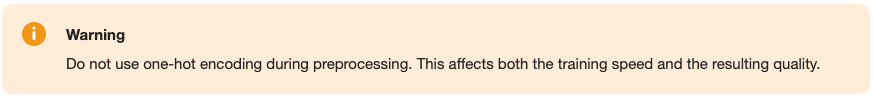

In [ ]:
feature_df = datasets['sales_init'].copy()
test_df = datasets['test_init'].copy()
test_df['sales'] = np.nan

feature_df = pd.concat([feature_df, test_df], axis=0)
feature_df.head()

## Add Store Features

In [ ]:
feature_df = feature_df.merge(datasets['stores_trans'],  how='left',  left_index=True,  right_index=True)
feature_df.drop(feature_df.filter(regex='_y$').columns, axis=1, inplace=True) 

feature_df['isclosed'] = feature_df.groupby(by=['date', 'store_nbr'])['sales'].transform(lambda x: 1 if x.sum()==0 else 0)
feature_df.loc[((feature_df.index.get_level_values('date').year==2017) & (feature_df.index.get_level_values('date').month==8) & (feature_df.index.get_level_values('date').day>=16)) , 'isclosed'] = feature_df['isclosed'].apply(lambda x: 0)
feature_df.head()

### Add Holidays Features

In [ ]:
feature_df = feature_df.merge(datasets['calendar'], how='left',  left_index=True, right_index=True, suffixes=('', '_y'))
feature_df.drop(feature_df.filter(regex='_y$').columns, axis=1, inplace=True) # Drop common columns after merge
feature_df.head()

### Add Oil Features

In [ ]:
# Lags and 7-days moving average
feature_df = feature_df.merge(datasets['oil_trans'], how='left',  left_index=True, right_index=True)
feature_df.head()

### Add Time Features
Now its time to add few extra time features

In [ ]:
feature_df['year'] = feature_df.index.get_level_values('date').year.astype('int')
feature_df['quarter'] = feature_df.index.get_level_values('date').quarter.astype('int')
feature_df['day'] = feature_df.index.get_level_values('date').day.astype('int')

feature_df['weekofyear'] = feature_df.index.get_level_values('date').week.astype('int')
feature_df['dayofweek'] = feature_df.index.get_level_values('date').day_of_week.astype('int')
feature_df['isweekend'] = feature_df.dayofweek.apply(lambda x: 1 if x in (5,6) else 0)

feature_df['newyear'] = feature_df.index.get_level_values('date').dayofyear == 1
feature_df['startschool'] = feature_df.index.get_level_values('date').month.isin((4,5,8,9))
feature_df['weekend'] = feature_df.index.get_level_values('date').dayofweek.isin((5,6))

# Wages in the public sector are paid every two weeks on the 15th and on the last day of the month
feature_df['wageday'] = ((feature_df.index.get_level_values('date').to_timestamp().is_month_end) | (feature_df.index.get_level_values('date').day == 15))

earthquake_affected_dates = [d.to_period('D') for d in pd.date_range('2016-04-16', periods=20, freq='D').tolist()]
feature_df['earthquake_Aprin2016_effect'] = feature_df.index.get_level_values('date').isin(earthquake_affected_dates)

feature_df['onpromotion_week_avg'] = feature_df['onpromotion'].rolling(7).mean()
feature_df['onpromotion_biweek_avg'] = feature_df['onpromotion'].rolling(14).mean()
feature_df['onpromotion_1_month_avg'] = feature_df['onpromotion'].rolling(30).mean()
feature_df['onpromotion_2_month_avg'] = feature_df['onpromotion'].rolling(60).mean()

feature_df.drop(columns=['city', 'cluster', 'state', 'store'], inplace=True)

### Promotion Features

In [ ]:
# Total Promotions by date
temp_df = feature_df[['onpromotion']].groupby(['date']).sum().rename(columns={'onpromotion':'total_daily_onpromotion'})

# Rolling Averages
temp_df['total_daily_onpromotion_week_avg'] = temp_df['total_daily_onpromotion'].rolling(7).mean()
temp_df['total_daily_onpromotion_biweek_avg'] = temp_df['total_daily_onpromotion'].rolling(14).mean()
temp_df['total_daily_onpromotion_1_month_avg'] = temp_df['total_daily_onpromotion'].rolling(30).mean()
temp_df['total_daily_onpromotion_2_month_avg'] = temp_df['total_daily_onpromotion'].rolling(60).mean()

# Lags
temp_df = create_lags(temp_df, target_col='total_daily_onpromotion', lags=5, suffix='_lag', drop_target=False)

feature_df = feature_df.merge(temp_df, how='left', left_index=True, right_index=True)

# Promotion Feature per Family.
temp_df = feature_df['onpromotion'].unstack('family').copy()
temp_df.columns = [f'{col}_onprom' for col in temp_df.columns.tolist()]
feature_df = feature_df.merge(temp_df, how='left', left_index=True, right_index=True)

del temp_df

### Add Time Deterministic Features

In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import CalendarFourier

fourierA = CalendarFourier(freq='A', order=5)
fourierM = CalendarFourier(freq='M', order=2)
fourierW = CalendarFourier(freq='W', order=3)

dp = DeterministicProcess(index=feature_df.index.get_level_values('date'),
                          order=1,
                          seasonal=True,
                          constant=False,
                          additional_terms=[fourierA, fourierM, fourierW],
                          drop=True)

dp_df = dp.in_sample()
feature_df = pd.concat([feature_df.reset_index(level=['store_nbr', 'family']), dp_df], axis=1)

# Set again the indexes
feature_df = feature_df.set_index(['store_nbr', 'family'], append=True)

# Model

## Helpers

In [ ]:
import time
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_log_error
from upgini import FeaturesEnricher, SearchKey, ModelTaskType
from upgini.metadata import CVType


def _scorer(y_true, y_predicted):
    y_true = np.exp(y_true)-1
    y_predicted = np.exp(y_predicted)-1
    return mean_squared_log_error(y_true, y_predicted, squared=False)

scorer = make_scorer(_scorer, greater_is_better=False)

def index_timeseries_train_test_split(df, date_index=False, date_format='%Y-%m-%d', earliest_train_date=None, split_date=None, last_test_date=None, verbose=True):
    """
    =======
    Example
    =======
    * earliest_train_date: 2020-02-01
    * split_date: 2020-04-01
    * last_test_date: 2020-07-01

    Timeline:
    ---------------------------------------------------------------------------------------------------
    dates --> 2020-01-01 ... 2020-02-01 ... 2020-03-01 ... 2020-04-01 .. 2020-07-01 ... 2020-10-01 ...
                                 /\                          /\             /\
                                 |                           |              |
                        earliest_train_date             split_date     last_test_date
    ---------------------------------------------------------------------------------------------------

    Finallly:
    ---------
    2020-02-01 <= TRAIN DATASET DATES < 2020-04-01
    2020-04-01 <= TEST DATASET DATES < 2020-07-01                              
    """
    dates = df.index.get_level_values('date').to_timestamp()

    if earliest_train_date:
        earliest_train_datetime = datetime.strptime(earliest_train_date, date_format)
        df = df.loc[[earliest_train_datetime<=date for date in dates]]
        dates = df.index.get_level_values('date').to_timestamp()

    if last_test_date:
        last_test_datetime = datetime.strptime(last_test_date, date_format)
        df = df.loc[[date<last_test_datetime for date in dates]]
        dates = df.index.get_level_values('date').to_timestamp()

    split_datetime = datetime.strptime(split_date, date_format)
    train_dates = [date<split_datetime for date in dates]
    test_dates = np.invert(train_dates)

    train_df = df.loc[train_dates]
    test_df =  df.loc[test_dates]

    if verbose:
        print('================================')
        print('Training Dataset last rows')
        ICD.display(train_df.tail(3))
        print('================================')
        print('Test Dataset first rows')
        ICD.display(test_df.head(3))

    return train_df, test_df


def separate_X_and_y(df, target='sales'):
    y = df[target].values
    X = df.drop(columns=target)
    return X, y


def unstack_transformation(X, y, group_by='date', target='sales', levels=['store_nbr', 'family']):
    df = X.copy()
    df[target] = y
    y = df.loc[:, target].unstack(levels)
    X = df.drop(columns=[target]).groupby(by=group_by).first()
    return X, y


def create_sample_weights(X, target_date, weight=0.9):
    extra_weight_days = X.index.get_level_values('date') > target_date
    return np.array(list(map(lambda x: np.exp(-weight) if x == 0 else 1, extra_weight_days.astype('int'))))


def get_closed_stores(df, last_days=15):
    closed_stores_df = df.groupby(['family']).tail(last_days).groupby(['family'])['sales'].sum().reset_index()
    closed_stores_df = closed_stores_df[closed_stores_df['sales'] == 0].drop('sales', axis = 1)
    closed_stores_df = closed_stores_df[closed_stores_df['family'] != "SCHOOL AND OFFICE SUPPLIES"]
    closed_stores_df = closed_stores_df.set_index(['family'])
    closed_stores_df['isclosed'] = True
    return closed_stores_df


def apply_zero_forecasting(df, closed_stores_df):
    df = df.merge(closed_stores_df, how='left',  left_index=True, right_index=True)
    df.loc[df['isclosed']==True, 'sales']=0
    df.drop(columns=['isclosed'], inplace=True)
    return df


def timeit(function):
    def wrapper(*args, **kwargs):
        ts = time.perf_counter()
        func = function(*args, **kwargs)
        te = time.perf_counter ()
        run_time = time.perf_counter() - ts
        print(f'Run Time: {run_time} secs')
        return func
    return wrapper


def plot_feature_importance(feature_importances, feature_names):
    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(feature_names, feature_importances):
        feats[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    importances.sort_values(by='Gini-importance').plot(kind='bar').show()


def plot_feature_elimination_score(min_features_to_select, grid_score):
    plt.figure()
    plt.xlabel('Number of features selected')
    plt.ylabel('Cross validation score')
    plt.plot(
        range(min_features_to_select, len(grid_score) + min_features_to_select),
        grid_score
    )
    plt.show()


def plot_predition_timeseries(x, y_actual, y_pred):
    df = pd.DataFrame()
    df['date'], df['actual'], df['prediction'] = x, y_actual, y_pred
    df = df.groupby(['date'], as_index=False).sum().reset_index()
    df['date'] = df['date'].apply(lambda row: row.to_timestamp())
    title = 'Actual vs Prediction'
    df.plot.line(x='date', y=['actual', 'prediction'], title=title).show()


def transform_prediction_to_df(X, y, prediction):
    return pd.DataFrame(pd.DataFrame(prediction,
                        index=X.index,
                        columns=y.columns).stack(['store_nbr'])).rename(columns={0: 'sales'})


def per_family_df_generator(train_df, test_df, verbose=False):
    families = sorted(train_df.index.get_level_values('family').unique())
    for _, family in zip(tqdm(range(len(families))), families):
        if verbose:
            print('='*40)
            print(f'Family: {family}')
        # Train DF   
        train_family_df = train_df[train_df.index.get_level_values('family')==family]
        train_family_df.index = train_family_df.index.droplevel('family')
        # Test DF 
        test_family_df = test_df[test_df.index.get_level_values('family')==family]
        test_family_df.index = test_family_df.index.droplevel('family')
        yield family, train_family_df, test_family_df


def cast_categorical(df, categorical_features):
    for col in df.columns:
        if col in categorical_features:
            df[col] = df[col].astype('category')

            
class UpginiEnricher:
    def __init__(self):
        self.enricher = FeaturesEnricher(
        search_keys={
            "date": SearchKey.DATE
        },
        country_code = "EC",
        model_task_type = ModelTaskType.REGRESSION,
        cv = CVType.time_series,
        )

    def fit(self, df):
        df = df.reset_index()[['date','sales']].groupby('date', as_index=False).mean()
        y = df['sales'].values
        X = df.drop(columns=['sales'])

        self.enricher.fit(
            X, 
            y,
            calculate_metrics=True,
            max_features=3)
        return self

    def transform(self, df):
        return self.enricher.transform(df.copy().reset_index(),
                                       keep_input=True,
                                       max_features=4, 
                                    ).set_index(['date', 'store_nbr'])

## Evaluate Model 💥
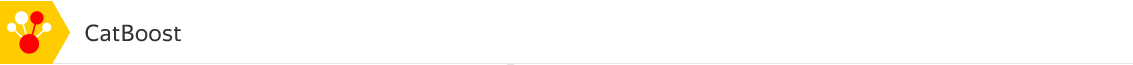

In [ ]:
train_df, test_df = index_timeseries_train_test_split(df=feature_df,
                                                      date_index='date',
                                                      date_format='%Y-%m-%d',
                                                      earliest_train_date='2013-03-01',
                                                      split_date='2017-07-15',
                                                      last_test_date='2017-08-01',
                                                      verbose=False)

In [ ]:
from sklearn.metrics import mean_squared_log_error
from catboost import Pool, CatBoostRegressor


def family_prediction_generator(train_df, test_df, estimator_params={}, plot_feature_importances=False, verbose=True):
    for family, train_family_df, test_family_df in per_family_df_generator(train_df, test_df, verbose=verbose):
        
        categorical_features = ['store_nbr', 'onpromotion', 'uniquestore', 'newstore', 'isclosed',
                                'wd', 'isevent', 'year', 'quarter', 'day', 'weekofyear', 'dayofweek',
                                'isweekend', 'newyear', 'startschool', 'weekend', 'wageday','earthquake_Aprin2016_effect']
        
        # =====================================
        # Upgini Enrich
        # =====================================
        if family in ['LIQUOR,WINE,BEER', 'CLEANING']:
            enricher = UpginiEnricher()
            enricher.fit(train_family_df)
            train_family_df = enricher.transform(train_family_df)
            test_family_df = enricher.transform(test_family_df)
        
        # =====================================
        # Create Training Pool
        # =====================================
        X_train, y_train = separate_X_and_y(train_family_df)
        weights = create_sample_weights(X_train, '2017-07-01')

        # Preprocessing steps
        X_train = X_train.reset_index()
        cast_categorical(X_train, categorical_features)
        X_train.drop(columns=['date'], inplace=True)

        train_pool = Pool(X_train,
                         np.log1p(y_train),
                         weight=weights,
                         feature_names=list(X_train.columns),
                         cat_features=categorical_features)

        # =====================================
        # Create Test Pool
        # =====================================
        X_test, y_test = separate_X_and_y(test_family_df)

        # Preprocessing steps
        X_test = X_test.reset_index()
        cast_categorical(X_train, categorical_features)
        X_test.drop(columns=['date'], inplace=True) 

        test_pool = Pool(X_test,
                         feature_names=list(X_test.columns),
                         cat_features=categorical_features)

        # =====================================
        # Setup Model
        # =====================================
        store_nbr_index = list(X_train.columns).index('store_nbr')
        estimator = CatBoostRegressor(iterations=2500, 
                                      #per_float_feature_quantization=f'{store_nbr_index}:border_count=1024',
                                      depth=8,
                                      #has_time=True,
                                      task_type="GPU",
                                      loss_function='RMSE',
                                      verbose=False)

        estimator.fit(train_pool,
                      early_stopping_rounds=50,
                      plot=False)
        
        if plot_feature_importances:
            feature_importances = estimator.get_feature_importance(train_pool)
            feature_names = X_train.columns
            plot_feature_importance(feature_importances, feature_names)     

        # =====================================
        # Test Prediction
        # =====================================
        test_prediction = estimator.predict(test_pool)
        test_prediction = (np.exp(test_prediction)-1).clip(0)
        test_pred_df = pd.DataFrame(test_prediction, index=test_family_df.index, columns=['sales'])
        test_pred_df['family'] = family
        test_pred_df = test_pred_df.set_index('family', append=True)
        
        # =====================================
        # Scoring
        # =====================================
        is_target_empty = any(np.isnan(test_family_df['sales'].values))
        if is_target_empty:
            # When the target is missing we are running in the test dataset
            # NOTE: We are not caclulating the training score in order to reduce the running time
            yield pd.DataFrame(), test_pred_df
        else:
            if verbose:
                # Create predictions for the training dataset
                train_prediction = estimator.predict(train_pool)
                train_prediction = (np.exp(train_prediction)-1).clip(0)
                train_pred_df = pd.DataFrame(train_prediction, index=train_family_df.index, columns=['sales'])
                train_pred_df['family'] = family
                train_pred_df = train_pred_df.set_index('family', append=True)
                
                family_train_score = mean_squared_log_error(train_family_df['sales'].values,
                                                            train_pred_df['sales'].values,
                                                            squared=False)
            
                family_test_score = mean_squared_log_error(test_family_df['sales'].values,
                                                           test_pred_df['sales'].values,
                                                           squared=False)
                
                print(f'RMSLE || TRAINING Score: {family_train_score}')
                print(f'RMSLE || TEST Score: {family_test_score}')
            yield train_pred_df, test_pred_df

In [ ]:
%%time
# NOTE: Only for notebook run in Kaggle I decreased the numbers in model in order
# to have a quicker run.
estimator_params = {
                    'extra_trees_n_estimators': 10,
                    'bagging_n_estimators': 5,
    
    }

training_total_pred_df = pd.DataFrame()
test_total_pred_df = pd.DataFrame()
for train_pred_df, test_pred_df in family_prediction_generator(train_df, test_df, estimator_params, plot_feature_importances=False):
    # Keep prediction for later plotting
    training_total_pred_df = pd.concat([training_total_pred_df, train_pred_df])
    test_total_pred_df = pd.concat([test_total_pred_df, test_pred_df])

In [ ]:
print('===> Print All stores Training Prediction')
training_total_pred_df = training_total_pred_df.sort_values(['date', 'store_nbr', 'family'])
training_score = mean_squared_log_error(train_df['sales'].values, training_total_pred_df['sales'].values, squared=False)
plot_predition_timeseries(x=training_total_pred_df.index.get_level_values('date'), 
                            y_actual=train_df['sales'].values,
                            y_pred=training_total_pred_df['sales'].values)

print('===> Print All stores Test Prediction')
test_total_pred_df = test_total_pred_df.sort_values(['date', 'store_nbr', 'family'])
test_score = mean_squared_log_error(test_df['sales'].values, test_total_pred_df['sales'].values, squared=False)
plot_predition_timeseries(x=test_total_pred_df.index.get_level_values('date'), 
                            y_actual=test_df['sales'].values,
                            y_pred=test_total_pred_df['sales'].values)

print(f'RMSLE || TRAINING Score: {training_score} | TEST Score: {test_score}')

# Final Training & Submission 🚀

In [ ]:
%%time
train_df, test_df = index_timeseries_train_test_split(df=feature_df,
                                                      date_index='date',
                                                      date_format='%Y-%m-%d',
                                                      earliest_train_date='2013-03-01',
                                                      split_date='2017-08-16',
                                                      verbose=True)

# Get stopped families for each store
closed_stores_df = get_closed_stores(train_df, last_days=15)
test_total_pred_df = pd.DataFrame()
for _, test_pred_df in family_prediction_generator(train_df, test_df):
    # Keep prediction for submission
    test_total_pred_df = pd.concat([test_total_pred_df, test_pred_df])

## Submit the results

In [ ]:
test_total_pred_df = test_total_pred_df.sort_values(['date', 'store_nbr', 'family'])

# Zero the sales for stopped families
test_total_pred_df= apply_zero_forecasting(test_total_pred_df, closed_stores_df)

ids = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv')['id']
test_total_pred_df['id'] = ids.values

submit_df = test_total_pred_df[['id', 'sales']]

if len(submit_df) != 28512: # Minor check before submission :-)
    raise Exception(f'The rows ({len(submit_df)}) of the export are not correct')
else:
    current_dateTime = datetime.now()
    latest_filename = 'submission.csv'

    submit_df.to_csv(latest_filename, index=False)
    print('Submition created successfully!!')